In [1]:
%matplotlib inline

import math

import astropy.units as u #Let's us assign units to values, which simplifies unit conversions.
import matplotlib.pyplot as plt #The plotting package
import numpy as np

import plasmapy as ppy

from plasmapy import formulary, particles #preset particle parameters and plasma functionality

# Helical motion of a charged particle in a constant magnetic field


Consider a single particle of mass $m$ and charge $q$ in a constant, uniform magnetic field $\mathbf{B}=B\ \hat{\mathbf{z}}$. We assume the Lorentz Force from the magnetic field is the only force present. The particle travels with velocity $\mathbf{v}$ governed by the force-balance equation

$$m\frac{d\mathbf{v}}{dt} = q\mathbf{v}\times\mathbf{B}$$

which says that the net force on the particle is equal to the Lorentz force. We can solve the O.D.E. to obtain: 

$$v_x =  v_\perp\cos\omega_c t \quad\mathrm{;}\quad v_y = -v_\perp\sin \omega_c t$$

where the parallel velocity $v_z$ remains constant. This exercise will help you plot this equation so you can see for yourself that the particle gyrates in a circular orbit in the $x,y$ plane with constant speed $v_\perp = v_x^2 + v_y^2$, gyrofrequency $\omega_c = \frac{\lvert q\rvert B}{m}$, and Larmor radius $r_L=\frac{v_\perp}{\omega_c}$.


For this example, we will look at one proton `p+` moving with velocity $v_x = 1\ m/s$ (so, in the $x$-direction only) at $t=0$. Let's define our initial parameters for the code. We will arbitrarily choose the strength of the magnetic field as 5 Tesla. We then use PlasmaPy's particles package to define a proton, and the formulary will automatically calculate the gyrofrequency $\omega_c$ for us. Then we set, in this case, $v_\perp = v_x = 1 \ m/s$. Finally, we use the formulary to calculate the Larmor radius, $r_L$.

In [3]:
# Initialize proton in uniform B field
B = 5 * u.T
proton = particles.Particle("p+")
omega_c = formulary.frequencies.gyrofrequency(B, proton)
v_perp = 1 * u.m / u.s
r_L = ppy.formulary.lengths.gyroradius(B, proton, Vperp=v_perp)

The function below evolves the particle's position according to the equations above describing $v_x,v_y$, and $v_z$. The option to add a constant drift velocity $v_d$ to the solution is included as an argument (which we will address later), though this drift velocity is zero by default:

In [4]:
def single_particle_trajectory(v_d=np.array([0, 0, 0])): #v_d is the drift velocity, which we define the default as 0
    # Set time resolution & velocity such that proton goes 1 meter along B per rotation
    T = 2 * math.pi / omega_c.value  # rotation period
    v_parallel = 1 / T * u.m / u.s #defines the parallel velocity (v_z, in this case as 1/T)
    dt = T / 1e2 * u.s #sets the time step at 1/100 of the period

    # Set initial particle position
    x = []
    y = []
    xt = 0 * u.m
    yt = -r_L

    # Evolve motion, AKA evaluate the equations interatively, with advancing time
    timesteps = np.arange(0, 10 * T, dt.value)
    for t in list(timesteps):
        v_x = v_perp * math.cos(omega_c.value * t) + v_d[0]
        v_y = v_perp * math.sin(omega_c.value * t) + v_d[1]
        xt += +v_x * dt
        yt += +v_y * dt
        x.append(xt.value)
        y.append(yt.value)
    x = np.array(x)
    y = np.array(y)
    z = v_parallel.value * timesteps

    return x, y, z

x, y, and z returned by this function are arrays containing the coordinates of the particle at a given time. We call the function (i.e. we tell it to run) with a line like this:

In [5]:
x, y, z = single_particle_trajectory()

We then plot the trajectory with matplotlib:

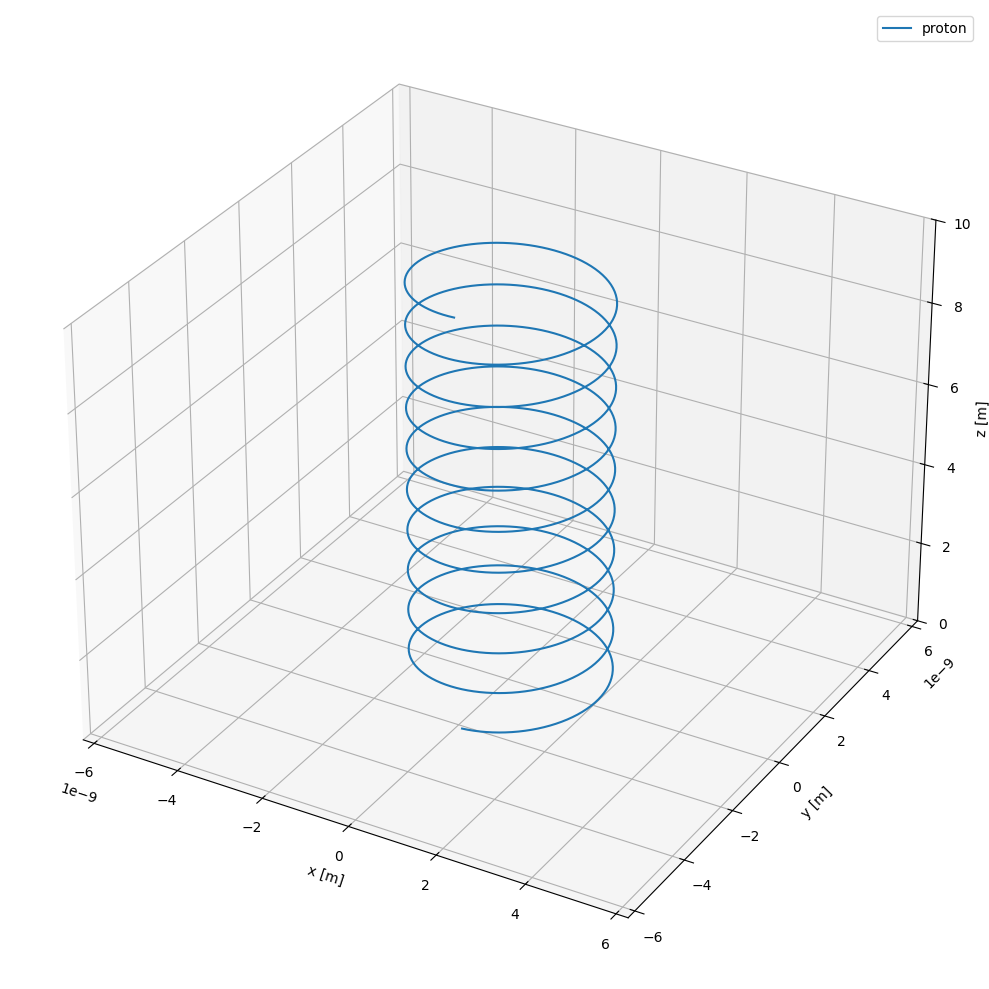

In [6]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.plot(x, y, z, label=r"proton")
ax.legend()
bound = 3 * r_L.value #sets the boundaries of the box to be 3x the larmor radius
ax.set_xlim([-bound, bound])
ax.set_ylim([-bound, bound])
ax.set_zlim([0, 10])
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_zlabel("z [m]")
fig.tight_layout()
plt.show()

Let's print the values of the Larmor radius and the gyrofrequency.

In [7]:
print(f"r_L = {r_L.value:.2e} m")
print(f"omega_c = {omega_c.value:.2e} rads/s")

r_L = 2.09e-09 m
omega_c = 4.79e+08 rads/s


But what if our particle was an electron, instead of a proton? How would the field or trajectory differ? Let's use all the same parameters as before (velocity, strength of the magnetic field) but change our particle to an electron, which will have a different mass and a different charge. This will give us a new Larmor radius and a new gyrofrequency. 

In [8]:
# Initialize electron in uniform B field
# B doesn't need to be redefined-- we leave it the same
electron = particles.Particle("e-")
omega_c = formulary.frequencies.gyrofrequency(B, electron)
#v_perp doesn't need to be redefined
r_L = formulary.lengths.gyroradius(B, electron, Vperp=v_perp)

We need to call our function again to recalculate the electrons' path.

In [9]:
x, y, z = single_particle_trajectory()

Let's print our gyrofrequency and larmor radius and plot the electron's path.

r_L = 1.14e-12 m
omega_c = 8.79e+11 rads/s


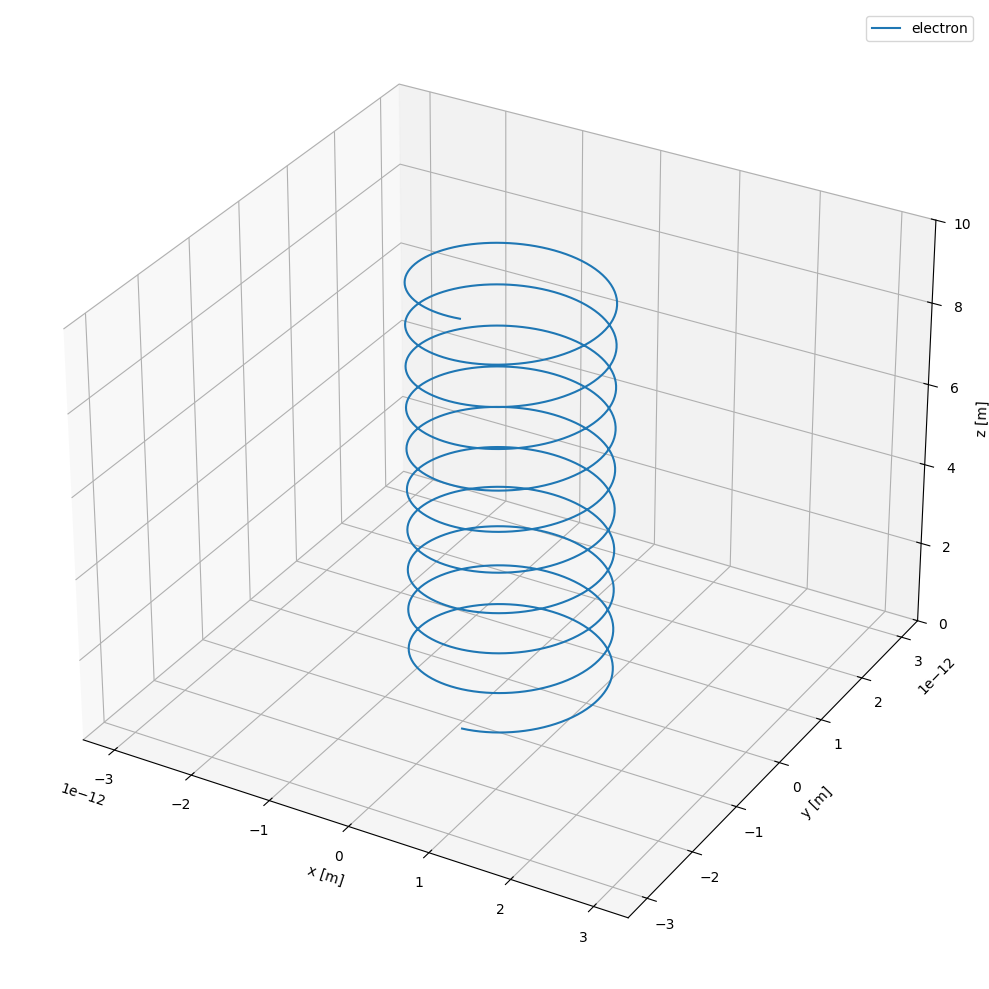

In [10]:
print(f"r_L = {r_L.value:.2e} m")
print(f"omega_c = {omega_c.value:.2e} rads/s")

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.plot(x, y, z, label=r"electron")
ax.legend()
bound = 3 * r_L.value #sets the boundaries of the box to be 3x the larmor radius
ax.set_xlim([-bound, bound])
ax.set_ylim([-bound, bound])
ax.set_zlim([0, 10])
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_zlabel("z [m]")
fig.tight_layout()
plt.show()

Hooray, we plotted it! But hmmm, it doesn't look much different, does it? We can see that our printed larmor radius is different, but the plots look the same due to automatic rescaling. Let's plot them together, so we can more easily compare the paths.

In order to do this, you need to have the electron and proton's trajectories saved separately. You will need to run single_particle_trajectory for both particles again, this time defining x, y, and z with new names for both so they don't overwrite each other. To do this, change the cell below from "Markdown" to "Code" and finish the code:

#define the frequency and radius for a proton
omega_c = formulary.frequencies.gyrofrequency(B, proton)
r_L = formulary.lengths.gyroradius(B, proton, Vperp=v_perp)

_,_,_ = single_particle_trajectory() #Fill in with names for the x, y, and z coordinates of the proton

r_L_p = r_L #save the larmor radius of the proton to set the boundaries of our plot

#define the frequency and radius for an electron
omega_c = formulary.frequencies.gyrofrequency(B, electron)
r_L = formulary.lengths.gyroradius(B, electron, Vperp=v_perp)

r_L_e = r_L #save the larmor radius for the electron too, for a calculation later

_,_,_  = single_particle_trajectory() #Fill in

Now let's plot both trajectories. Change the cell below to Code and fill in what you named the coordinates of your trajectories:

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

ax.plot( , , , label=r"proton") #Fill in
ax.plot( , , , label=r"electron") #Fill in

ax.legend()
bound = 1.1 * r_L_p.value #we zoom in more than our previous plot
ax.set_xlim([-bound, bound])
ax.set_ylim([-bound, bound])
ax.set_zlim([0, 10])
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_zlabel("z [m]")
fig.tight_layout()
plt.show()

Wow, the radius of the electron's path is so much smaller, it just looks like a line! This makes sense if we look at the ratio of the larmor radii:

In [ ]:
r_L_p/r_L_e

So the radius of the proton is about 1800x that of the electron. Not unsurprisingly, this is due to the difference in the mass between the two particles. We can see this by noting that the radii depend on the gyrofrequency, which, when $B$ and $|q|$ are the same:

$$ \frac{r^{p}_L}{r^{e}_L} = \frac{\omega^{e}_c}{\omega^{p}_c} = \frac{m_{p}}{m_{e}}$$

Let's calculate the ratio of the proton's mass to the electron's mass, which we can call using the Particles subpackage of PlasmaPy:

In [ ]:
particles.particle_mass('p+')/particles.particle_mass('e-')

...exactly the ratio of the Larmor radii.

# Physics of the E×B drift

Previously, we considered a single particle of mass $m$ and charge $q$ in a constant, uniform magnetic field $\mathbf{B}=B\ \hat{\mathbf{z}}$. We assumed the Lorentz Force from the magnetic field was the only force present, and so had the equation:

$$m\frac{d\mathbf{v}}{dt} = q\mathbf{v}\times\mathbf{B}$$

which says that the net force on the particle is equal to the Lorentz force. However, in reality there are likely to be many other forces acting on a particle. To begin, we won't specify what that force is, we will just label it a generic $\mathbf{F}$. 


The new equation of motion is

$$m\frac{d\mathbf{v}}{dt} = q\mathbf{v}\times\mathbf{B} + \mathbf{F}$$.

To find $\mathbf{v}$, we are going to assume it is the sum of its parts, $\mathbf{v}=\mathbf{v}_\parallel + \mathbf{v}_L + \mathbf{v}_d$. Here, $\mathbf{v}_\parallel$ is the velocity parallel to the magnetic field, $\mathbf{v}_L$ is the Larmor gyration velocity found previously without the extra $\mathbf{F}$, and $\mathbf{v}_d$ is a constant drift velocity perpendicular to the magnetic field that arises from the new force. You'll see why it is called a "drift" later.

Well that seems like a lot to handle! Let's break this down into parts, specifically we can separate the parallel from the perpendicular parts. Remember that cross product takes the projection of the first vector onto the second--so it only takes the perpendicular part of the velocity. $v_\parallel$ is self-evidently parallel, so $\mathbf{v}_\parallel \times \mathbf{B} = 0$. $\mathbf{v}_L$ is also parallel to the magnetic field (draw a diagram of the particles motion from the Helical Motion exercise if you are unconvinced). So, only the $\mathbf{B}\times \mathbf{v}_d$ part remains, and the result of the cross product will be perpendicular to $\mathbf{B}$.

We plug in our velocities for $\mathbf{v}$ and remember that $\mathbf{v}_L$ and $\mathbf{v}_d$ are constant in time:

$$m\frac{d\mathbf{v}_\parallel}{dt} + m\cancel{\frac{d (\mathbf{v}_L + \mathbf{v}_d)}{dt}} = q(\cancel{\mathbf{v}_\parallel + \mathbf{v}_L} + \mathbf{v}_d)\times\mathbf{B} + \mathbf{F}$$

$$m\frac{d\mathbf{v}_\parallel}{dt} = q\mathbf{v}_d \times \mathbf{B} + \mathbf{F}$$

Then, splitting $\mathbf{F}$ into its parallel and perpendicular parts:

$$F_\parallel = m\frac{dv_\parallel}{dt} \quad\mathrm{and}\quad \mathbf{F}_\perp = q\mathbf{B}\times \mathbf{v}_d$$

The drift velocity is the one we care about, so we take the second equation and use some vector algebra, specifically the triple vector product $\mathbf{A} \times (\mathbf{B} \times \mathbf{C}) = \mathbf{B}(\mathbf{A} \cdot \mathbf{C}) - \mathbf{C}(\mathbf{A} \cdot \mathbf{B}) $, to get:

$$\mathbf{v}_d = \frac{1}{q}\frac{\mathbf{F}_\perp\times\mathbf{B}}{B^2}$$



[force_drift]:https://docs.plasmapy.org/en/stable/api/plasmapy.formulary.drifts.force_drift.html
[ExB_drift]:https://docs.plasmapy.org/en/latest/api/plasmapy.formulary.drifts.ExB_drift.html

A common force of note in plasmas is the one arising from a constant electric field. The Coulomb Force Equation tells us that $\mathbf{F} = q\mathbf{E}$, so let's add this in for our force:

$$\boxed{
    \mathbf{v}_d = \frac{\mathbf{E}\times\mathbf{B}}{B^2}
    }$$

Now we can calculate the drift velocity as long as we know $\mathbf{E}$ and $\mathbf{B}$.

PlasmaPy has some functions that will calculate the drift velocity for us. There are two, in fact, in the formulary: [force_drift] and [ExB_drift]. First, let's initialize our proton in the magnetic field, as we did in Helical Motion, assuming $\mathbf{B} = B\hat{\mathbf{z}}$.


In [ ]:
# Initialize proton in uniform B field
B = 5 * u.T
proton = particles.Particle("p+")
omega_c = formulary.frequencies.gyrofrequency(B, proton)
v_perp = 1 * u.m / u.s
r_L = formulary.lengths.gyroradius(B, proton, Vperp=v_perp)

In [ ]:
#Calculate the drift velocity vector

E = 0.2 * u.V / u.m  # E-field magnitude
ey = np.array([0, 1, 0]) #y unit vector
ez = np.array([0, 0, 1]) #z unit vector
F = proton.charge * E  # magnitude of the force due to E-field 

#method 1
v_d = formulary.drifts.force_drift(F * ey, B * ez, proton.charge)
print("F drift velocity: ", v_d)

#method 2
v_d = formulary.drifts.ExB_drift(E * ey, B * ez)
print("ExB drift velocity: ", v_d)

Next we have our same single_particle_trajectory function as before, which will evolve the particle's position according to the equations above by calculating $v_x,v_y$, and $v_z$ in small timesteps. This time, we will add our drift velocity $v_d$ to the solution. 

Note: The drift velocity is a vector that may have x, y, and a z component. It is not just a number. Notice how the code handles the array of v_d to account for this--it is just like vector addition where you make sure to add the x parts, y parts, etc. The code defines 2, 3D arrays with 0s and 1s. These are like the unit vectors you may remember from an Algebra course.

We do have to specify the Electric field, which we decide will point in the $y$ direction, $\mathbf{E} = E \hat{\mathbf{y}}$

In [ ]:
#Evolve the particle trajectory

def single_particle_trajectory(v_d=np.array([0, 0, 0])):
    # Set time resolution & velocity such that proton goes 1 meter along B per rotation
    T = 2 * math.pi / omega_c.value  # rotation period
    v_parallel = 1 / T * u.m / u.s #defines the parallel velocity (v_z, in this case as 1/T)
    dt = T / 1e2 * u.s #sets the time step at 1/100 of the period

    # Set initial particle position
    x = []
    y = []
    xt = 0 * u.m
    yt = -r_L

    # Evolve motion, AKA evaluate the equations step by step
    timesteps = np.arange(0, 10 * T, dt.value)
    for t in list(timesteps):
        v_x = v_perp * math.cos(omega_c.value * t) + v_d[0]
        v_y = v_perp * math.sin(omega_c.value * t) + v_d[1]
        xt += +v_x * dt
        yt += +v_y * dt
        x.append(xt.value)
        y.append(yt.value)
    x = np.array(x)
    y = np.array(y)
    z = v_parallel.value * timesteps

    return x, y, z

Previously we left the parenthesis empty when we called our function. This time, we tell it to set the drift velocity equal to our calculated v_d, which overrides the 0 default.

In [ ]:
x_d, y_d, z_d = single_particle_trajectory(v_d=v_d) 

Let's also calculate the trajectory without the drift, just so we can compare. Then we will plot the results together.

In [ ]:
x, y, z = single_particle_trajectory()

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.plot(x, y, z, label=r"$\mathbf{F}=0$")
ax.plot(x_d, y_d, z_d, label=r"$\mathbf{F}=q\mathbf{E}$")

bound = 2.5 * r_L.value
ax.set_xlim([-bound, bound])
ax.set_ylim([-bound, bound])
ax.set_zlim([0, 10])
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_zlabel("z [m]")
fig.tight_layout()
ax.legend()
plt.show()

Now you can see why it is called a "drift" velocity. The new force leaves the helical motion unchanged, but it causes the center of the motion, called the \textbf{guiding center}, to drift. This drift velocity is very important to account for during fusion experiments--it causes particles, and therefore heat, to accumulate near the edges of a fusion reactor, leading to an inefficient burn at best and complete meltdown at worst. And that is just one example--the drift is important to many plasma phenomena.

What if $\mathbf{E}$ was in the $x$ direction instead? Change the Markdown in the cell below to Code, and fill in the vector.

ex = np.array([ , , ]) #Fill in the array to make an x unit vector

v_d = formulary.drifts.force_drift(F * ex, B * ez, proton.charge)
print("F drift velocity: ", v_d)


In [ ]:
x_d, y_d, z_d = single_particle_trajectory(v_d=v_d) 

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.plot(x, y, z, label=r"$\mathbf{F}=0$")
ax.plot(x_d, y_d, z_d, label=r"$\mathbf{F}=q\mathbf{E}$")

bound = 2.5 * r_L.value
ax.set_xlim([-bound, bound])
ax.set_ylim([-bound, bound])
ax.set_zlim([0, 10])
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_zlabel("z [m]")
fig.tight_layout()
ax.legend()
plt.show()

Can you specify an electric field with $x$ and $y$ components, and plot the result? Change the cell below to Code.

v_d = formulary.drifts.force_drift(F * (add ex and ey unit vectors together), B * ez, proton.charge) #Fill in for the unit vectors
print("F drift velocity: ", v_d)

In [ ]:
x_d, y_d, z_d = single_particle_trajectory(v_d=v_d) 

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.plot(x, y, z, label=r"$\mathbf{F}=0$")
ax.plot(x_d, y_d, z_d, label=r"$\mathbf{F}=q\mathbf{E}$")

bound = 2.5 * r_L.value
ax.set_xlim([-bound, bound])
ax.set_ylim([-bound, bound])
ax.set_zlim([0, 10])
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_zlabel("z [m]")
fig.tight_layout()
ax.legend()
plt.show()